# Orchestrator-Worker: Langgraph 와 Langfuse 로 Amazon Bedrock 시작하기

이 노트북은 [Langfuse](https://langfuse.com/) 를 사용하여 Amazonb Bedrock 의 LLM 을 사용하는 방법을 
가이드하는 노트북 입니다.

구체적으로 LangGraph 로 Orchestrator-Worker 하는 방법을 배웁니다.

### 참조
- [LangGraph: Workflows and Agents](https://langchain-ai.github.io/langgraph/tutorials/workflows/#prompt-chaining)
- [Map-reduce](https://github.com/langchain-ai/langchain-academy/blob/main/module-4/map-reduce.ipynb)



---

## 1. 선수 사항: 
### 1.1 Langfuse 사용 환경 및 콘다 가상 환경 생성
- 아래의 설치 가이드에 따라 먼저 진행 해주세요.
    - [환경 설치 가이드: ](https://github.com/aws-samples/aws-ai-ml-workshop-kr/tree/master/genai/aws-gen-ai-kr/20_applications/19_agentic_rag)


### 1.2. Key 정보를 저장하는 env 파일 생성
-  ../../.env 파일을 생성하고 아래의 내용을 작성, 19_agentic_rag 폴더 아래에 생성 하시면 됩니다.
    ```
    LANGFUSE_SECRET_KEY=<secret key>
    LANGFUSE_PUBLIC_KEY=<public key>
    LANGFUSE_HOST=<host url>
    ```    

## 2. 환경 설정

In [1]:
%load_ext autoreload
%autoreload 2

import sys, os

def add_python_path(module_path):
    if os.path.abspath(module_path) not in sys.path:
        sys.path.append(os.path.abspath(module_path))
        print(f"python path: {os.path.abspath(module_path)} is added")
    else:
        print(f"python path: {os.path.abspath(module_path)} already exists")
    print("sys.path: ", sys.path)


module_path = ".."
add_python_path(module_path)

from utils.langgraph_util import ( 
    show_graph_dag,
)

python path: /home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/19_agentic_rag/07_start_langgraph_bedrock_langfuse is added
sys.path:  ['/home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/19_agentic_rag/07_start_langgraph_bedrock_langfuse/03_langgraph', '/home/sagemaker-user/.conda/envs/langgraph/lib/python310.zip', '/home/sagemaker-user/.conda/envs/langgraph/lib/python3.10', '/home/sagemaker-user/.conda/envs/langgraph/lib/python3.10/lib-dynload', '', '/home/sagemaker-user/.conda/envs/langgraph/lib/python3.10/site-packages', '/home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/19_agentic_rag/07_start_langgraph_bedrock_langfuse']


## 3. 환경 변수 로딩
아래와 같은 환경 변수를 로딩 함.
```
LANGSMITH_TRACING=true
LANGSMITH_API_KEY=your_langsmith_api_key
OPENAI_API_KEY=your_openai_api_key
```

In [2]:
from dotenv import load_dotenv

# .env 파일에서 환경 변수 로드
load_dotenv("../../.env")



True

## 4. langfuse_handler 핸들러 작성하기

In [3]:
from langfuse.callback import CallbackHandler
import os

langfuse_handler = CallbackHandler(
    public_key=os.environ.get('LANGFUSE_PUBLIC_KEY'),
    secret_key=os.environ.get('LANGFUSE_SECRET_KEY'),
    host=os.environ.get('LANGFUSE_HOST'),
)

### langfuse endpoint 에 인증 해보기

In [4]:
# connection test
langfuse_handler.auth_check()

True

## 5. LangChain 인터페이스의 Bedrock 모델 생성
- LangChain 개발자 가이드: [ChatBedrock](https://python.langchain.com/docs/integrations/chat/bedrock/)

]

In [5]:
from langchain_aws import ChatBedrockConverse

# model_id = "us.anthropic.claude-3-7-sonnet-20250219-v1:0"
# model_id = "us.amazon.nova-pro-v1:0"
model_id = "us.anthropic.claude-3-5-haiku-20241022-v1:0"

llm = ChatBedrockConverse(
    model= model_id,
    temperature=0,
    max_tokens=None,
    # other params...
)

llm

ChatBedrockConverse(client=<botocore.client.BedrockRuntime object at 0x7f04d153c250>, model_id='us.anthropic.claude-3-5-haiku-20241022-v1:0', temperature=0.0, region_name='us-east-1', provider='anthropic', supports_tool_choice_values=('auto', 'any', 'tool'))

## 6. Grpah 정의 하기

In [6]:
from pydantic import BaseModel, Field
from typing import Annotated, List
import operator
from langchain_core.messages import SystemMessage, HumanMessage


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

### State 정의

In [7]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

from langgraph.constants import Send

# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

### Node 및 분기  함수 정의

In [8]:
# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a short plan for the report in Korean."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


In [9]:
def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}

In [10]:
def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}

In [11]:
# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

### 그래프 구조 만들기

In [12]:
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

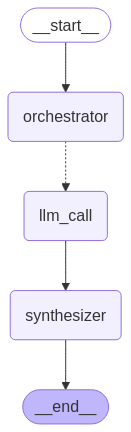

In [13]:
# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))


### Graph 호출

In [14]:
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"},
    config={
            "callbacks": [langfuse_handler],
        }
)

### 최종 State 값 보기
- 각 Node 에서 State Class 의 변수에 값을 할당함.

In [15]:
state

{'topic': 'Create a report on LLM scaling laws',
 'sections': [Section(name='소개', description='대규모 언어 모델(LLM)의 스케일링 법칙에 대한 기본 개념 및 중요성 설명'),
  Section(name='스케일링 법칙의 기본 원리', description='모델 크기, 데이터 양, 계산 능력이 성능에 미치는 영향 분석'),
  Section(name='주요 연구 및 발견', description='OpenAI, DeepMind 등 주요 연구 기관의 LLM 스케일링 법칙 연구 결과 검토'),
  Section(name='성능 예측 및 한계', description='스케일링 법칙을 통한 모델 성능 예측 방법과 현재의 기술적 한계 탐구'),
  Section(name='미래 전망', description='LLM 스케일링의 미래 트렌드와 잠재적 발전 방향 논의')],
 'completed_sections': ['## 소개\n\n대규모 언어 모델(Large Language Models, LLM)의 발전은 인공지능 분야에서 혁명적인 변화를 가져왔다. 이러한 모델의 성능은 모델 크기, 학습 데이터, 컴퓨팅 파워와 밀접한 관련이 있으며, 스케일링 법칙는 이러한 관계를 이해하는 핵심 개념이다.\n\n스케일링 법칙은 모델의 크기(매개변수 수)와 성능 사이의 상관관계를 설명한다. 주요 관찰 결과는 다음과 같다:\n\n1. **매개변수 규모**: 모델의 매개변수 수가 증가함에 따라 성능이 지수적으로 향상된다.\n2. **데이터 의존성**: 더 큰 모델은 더 많은 학습 데이터를 필요로 하며, 데이터 품질과 다양성이 중요하다.\n3. **컴퓨팅 요구사항**: 모델 크기 증가에 따라 계산 복잡성과 학습 비용도 증가한다.\n\n이러한 스케일링 법칙의 이해는 AI 연구자들에게 중요한 통찰을 제공하며, 미래 언어 모델의 성능 예측과 개발 방향을 제시한다. 본 연구에서는 이러한 스케일링 법칙의 기본 개념과 그 중요

### State 값 흐름에 따라 출력

In [16]:
from IPython.display import Markdown
Markdown(state["final_report"])

## 소개

대규모 언어 모델(Large Language Models, LLM)의 발전은 인공지능 분야에서 혁명적인 변화를 가져왔다. 이러한 모델의 성능은 모델 크기, 학습 데이터, 컴퓨팅 파워와 밀접한 관련이 있으며, 스케일링 법칙는 이러한 관계를 이해하는 핵심 개념이다.

스케일링 법칙은 모델의 크기(매개변수 수)와 성능 사이의 상관관계를 설명한다. 주요 관찰 결과는 다음과 같다:

1. **매개변수 규모**: 모델의 매개변수 수가 증가함에 따라 성능이 지수적으로 향상된다.
2. **데이터 의존성**: 더 큰 모델은 더 많은 학습 데이터를 필요로 하며, 데이터 품질과 다양성이 중요하다.
3. **컴퓨팅 요구사항**: 모델 크기 증가에 따라 계산 복잡성과 학습 비용도 증가한다.

이러한 스케일링 법칙의 이해는 AI 연구자들에게 중요한 통찰을 제공하며, 미래 언어 모델의 성능 예측과 개발 방향을 제시한다. 본 연구에서는 이러한 스케일링 법칙의 기본 개념과 그 중요성을 심층적으로 탐구한다.

---

## 스케일링 법칙의 기본 원리

스케일링 법칙은 인공지능 모델의 성능 향상을 위한 핵심 메커니즘으로, 세 가지 주요 변수의 상호작용을 분석한다:

### 모델 크기 (파라미터 수)
- 모델의 파라미터 수가 증가함에 따라 성능이 개선되는 경향
- 대규모 언어 모델에서 파라미터 스케일링의 중요성
- 모델 복잡성과 학습 능력 간의 상관관계

### 데이터 양
- 학습 데이터의 규모가 모델 성능에 미치는 영향
- 데이터 다양성과 품질의 중요성
- 데이터 스케일링을 통한 일반화 능력 향상

### 계산 능력
- 컴퓨팅 리소스의 확장이 모델 학습에 미치는 영향
- 병렬 처리 및 분산 학습 기술
- 계산 효율성과 모델 성능 간의 균형

### 스케일링 법칙의 주요 관찰
- 로그-선형적 성능 개선 패턴
- 모델 크기, 데이터 양, 계산 능력 간의 상호 의존성
- 리소스 투자 대비 성능 향상의 수익성 분석

### 한계 및 도전 과제
- 무제한 스케일링의 기술적, 경제적 제약
- 모델 복잡성 증가에 따른 과적합 위험
- 에너지 소비 및 환경적 고려사항

---

## 주요 연구 및 발견

최근 OpenAI와 DeepMind를 중심으로 대규모 언어 모델(LLM)의 스케일링 법칙에 대한 중요한 연구 결과들이 발표되었다.

### OpenAI의 스케일링 연구

OpenAI의 연구팀은 모델 크기, 학습 데이터, 컴퓨팅 성능 간의 상관관계를 분석하여 다음과 같은 주요 발견을 제시했다:

- 모델 크기가 증가함에 따라 성능이 로그 선형적으로 개선됨
- 학습 데이터의 양과 질이 모델 성능에 결정적 영향을 미침
- 컴퓨팅 파워 증가가 모델 성능 향상의 핵심 요인

### DeepMind의 스케일링 인사이트

DeepMind 연구팀은 다음과 같은 중요한 관찰 결과를 도출했다:

- 모델 크기 증가에 따른 성능 향상의 한계점 존재
- 다양성과 고품질 데이터셋의 중요성
- 모델 아키텍처 최적화의 필요성

### 주요 시사점

- 지속적인 모델 스케일링은 성능 개선에 유효한 전략
- 단순한 크기 확장보다는 데이터와 아키텍처 최적화가 중요
- 계산 효율성과 성능 사이의 균형 필요

---

## 성능 예측 및 한계

### 스케일링 법칙 분석

대규모 언어 모델의 성능 예측을 위해 다음과 같은 주요 스케일링 법칙을 고려할 수 있다:

- 모델 크기 증가에 따른 성능 향상 추세
- 학습 데이터 규모와 성능 간의 상관관계
- 계산 리소스 확장에 따른 성능 변화

### 기술적 한계

현재 대규모 언어 모델의 주요 한계점:

1. **계산 리소스 제약**
   - 극도로 큰 모델의 학습 및 추론에 필요한 막대한 컴퓨팅 파워
   - 에너지 소비 및 환경적 영향

2. **데이터 품질 및 편향**
   - 학습 데이터의 편향성
   - 희소한 고품질 데이터의 한계

3. **성능 포화 현상**
   - 모델 크기 증가에 따른 성능 향상의 점진적 감소
   - 한계 효용 체감 현상

### 미래 전망

- 보다 효율적인 모델 아키텍처 개발
- 계산 효율성 개선 연구
- 데이터 큐레이션 및 편향 감소 기술 발전

---

## 미래 전망

LLM(대규모 언어 모델) 기술의 미래 발전 방향은 다음과 같은 주요 트렌드를 중심으로 전개될 것으로 예상된다:

### 모델 규모와 성능 확장
- 파라미터 수의 지속적인 증가
- 더욱 정교한 학습 알고리즘 개발
- 계산 효율성 및 에너지 소비 최적화

### 다중 모달 통합
- 텍스트, 이미지, 음성, 비디오 등 다양한 데이터 유형 통합
- 크로스 모달 학습 및 추론 능력 강화
- 보다 복합적이고 맥락 인식적인 AI 시스템 구현

### 윤리적 AI 및 편향성 감소
- 알고리즘 공정성 개선
- 편향된 학습 데이터 문제 해결
- 투명성과 설명 가능성 증대

### 특화된 도메인 모델
- 의료, 법률, 과학 등 특정 분야 전문 LLM 개발
- 고도의 전문성과 정확성을 갖춘 AI 솔루션 제공

### 상호작용성 및 개인화
- 사용자 맥락에 더욱 민감한 대화형 인터페이스
- 개인화된 학습 및 적응 능력 향상
- 실시간 피드백 및 상호작용 메커니즘 개선

이러한 트렌드는 LLM 기술의 지속적인 혁신과 사회적 영향력 확대를 예고하고 있다.

## 7. Langfuse Tracing Output
![orchestrator-worker.png](img/orchestrator-worker.png)